In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path  # type: ignore
# import seaborn as sns
import joblib
import pickle
import mordred
from mordred import Calculator, descriptors
from typing import * # import all the type hints (wildcard import)
import tqdm  # type: ignore (this is connected with the progress bar _pbar)
from stoned_utils import *

# import pubchempy as pcp

import rdkit
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity, TanimotoSimilarity  # type: ignore
# from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors, rdMolDescriptors, rdDepictor
# from rdkit.Chem.Draw import IPythonConsole


# import rdkit, rdkit.Chem, rdkit.Chem.Draw
# from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem import Draw
# from rdkit.Chem.Draw import rdMolDraw2D


# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# import io
# import PIL.Image
# from PIL import ImageDraw, ImageFont



# import mordred, mordred.descriptors
# from mordred import HydrogenBond, Polarizability
# from mordred import SLogP, AcidBase, BertzCT, Aromatic, BondCount, AtomCount
# from mordred import Calculator

import exmol as exmol
from stoned import stoned
import selfies as sf  # type: ignore
# from rdkit.Chem.Draw import rdDepictor
# import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_auc_score, plot_roc_curve
# from sklearn.multioutput import MultiOutputRegressor
# from sklearn.linear_model import Ridge

from spectrum_func import *

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# rdDepictor.SetPreferCoordGen(True)

# IPythonConsole.ipython_useSVG = True
# color_cycle = ["#F06060", "#1BBC9B", "#F3B562", "#6e5687", "#5C4B51"]
# mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=color_cycle)
# np.random.seed(0)


Stoned is running from the spectrum directory


In [2]:
optdata = pd.read_csv("data/DB_for_chromophore_Sci_Data_rev02.csv")
optdata.columns = ['Tag', 'SMILES', 'Solvent', 'LambdaMaxAbs', 'LambdaMaxEm', 'Lifetime', 'QY', 'LogExtCoeff', 'AbsFWHMcm-1', 'EmFWHMcm-1', 'AbsFWHMnm', 'EmFWHMnm', 'MolarMass', 'reference']
features_start_at = list(optdata.columns).index("LambdaMaxAbs")
# scramble them
optdata = optdata.sample(frac=1.0, random_state=0).reset_index(drop=True)
optdata.head()

,Tag,Chromophore,Solvent,LambdaMaxAbs,LambdaMaxEm,Lifetime,QY,LogExtCoeff,AbsFWHMcm-1,EmFWHMcm-1,AbsFWHMnm,EmFWHMnm,MolarMass,reference
0,16295,[O-]c1c(-c2ccccc2)cc(-[n+]2c(-c3ccccc3)cc(-c3c...,Cc1ccncc1,723.822785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,551.68726,https://doi.org/10.1021/cr00032a005
1,5187,CN(C)c1ccc(C2=Cc3c4ccccc4cc[n+]3[B-](F)(F)O2)cc1,CC#N,458.000000,552.0,NaN,0.6380,4.522444,3326.0,2672.5,NaN,NaN,338.16398,https://doi.org/10.1016/j.saa.2018.03.048
2,8308,COc1cccc2cc(-c3cc4cccc(OC)c4oc3=O)oc12,CS(C)=O,359.000000,488.0,NaN,0.1100,4.457882,NaN,NaN,NaN,NaN,322.31516,DOI: 10.1021/acs.orglett.7b00069
3,11000,Cc1cc(-c2ccc(C(C)(C)C)cc2)cc(C)[o+]1,ClCCl,365.000000,417.0,2.1,0.2500,4.531479,3617.0,NaN,NaN,NaN,241.35274,https://doi.org/10.1016/S0009-2614(97)00140-1
4,13139,C(=C/c1cnc2ccccc2n1)\c1cnccn1,ClCCl,NaN,430.0,NaN,0.0014,NaN,NaN,NaN,NaN,NaN,234.26140,https://doi.org/10.1016/1010-6030(92)85164-P


In [3]:
working_df = optdata.copy()
working_df.head()


,Tag,Chromophore,Solvent,LambdaMaxAbs,LambdaMaxEm,Lifetime,QY,LogExtCoeff,AbsFWHMcm-1,EmFWHMcm-1,AbsFWHMnm,EmFWHMnm,MolarMass,reference
0,16295,[O-]c1c(-c2ccccc2)cc(-[n+]2c(-c3ccccc3)cc(-c3c...,Cc1ccncc1,723.822785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,551.68726,https://doi.org/10.1021/cr00032a005
1,5187,CN(C)c1ccc(C2=Cc3c4ccccc4cc[n+]3[B-](F)(F)O2)cc1,CC#N,458.000000,552.0,NaN,0.6380,4.522444,3326.0,2672.5,NaN,NaN,338.16398,https://doi.org/10.1016/j.saa.2018.03.048
2,8308,COc1cccc2cc(-c3cc4cccc(OC)c4oc3=O)oc12,CS(C)=O,359.000000,488.0,NaN,0.1100,4.457882,NaN,NaN,NaN,NaN,322.31516,DOI: 10.1021/acs.orglett.7b00069
3,11000,Cc1cc(-c2ccc(C(C)(C)C)cc2)cc(C)[o+]1,ClCCl,365.000000,417.0,2.1,0.2500,4.531479,3617.0,NaN,NaN,NaN,241.35274,https://doi.org/10.1016/S0009-2614(97)00140-1
4,13139,C(=C/c1cnc2ccccc2n1)\c1cnccn1,ClCCl,NaN,430.0,NaN,0.0014,NaN,NaN,NaN,NaN,NaN,234.26140,https://doi.org/10.1016/1010-6030(92)85164-P


## Filter out NaNs for LogExtCeoff and LambdaMaxAbs

In [4]:
optdata_LambdaMaxAbs = working_df[(~working_df["LambdaMaxAbs"].isna())]
optdata_LogExtCoeff = working_df[(~working_df["LogExtCoeff"].isna())]
working_df_LogExtCoeff = optdata_LogExtCoeff.copy()
working_df_LambdaMaxAbs = optdata_LambdaMaxAbs.copy()

## Obtain features for RF model using mordred, and assign LogExtCoeff values as associated y "Values".

In [5]:
optdata_LogExtCoeff.index

Int64Index([    1,     2,     3,     6,    10,    11,    13,    17,    18,
               19,
            ...
            20219, 20221, 20223, 20224, 20228, 20229, 20230, 20232, 20233,
            20234],
           dtype='int64', length=8041)

In [6]:
# Define a list of descriptor groups to exclude
exclude_groups = ['MoreauBrotoAutocorrelation', 'GearyAuto', 'MoranAuto', 'BaryszMatrix']

# Remove the undesired descriptor groups from the list of descriptors
descriptors_to_use = []
for desc in descriptors.__all__:
    if desc not in exclude_groups:
        descriptors_to_use.append(getattr(descriptors, desc))

# Make object that can compute descriptors
calc = Calculator(descriptors_to_use, ignore_3D=True)


In [37]:

def get_mol_and_labels(calculators, df, property: str = None, filepath: str = None):
    if property is not None: 
                
        # Load molecules from valid SMILES strings
        molecules = []
        labels = []
        for i, smi in zip(df.index, df.SMILES):
            mol = rdkit.Chem.MolFromSmiles(smi)
            if mol:
                molecules.append(mol)
                labels.append(df.loc[i][property])
        # calculating mordred features is time consuming so we work with precalculated features
        try:
            raw_features = pd.read_pickle(filepath)
        except FileNotFoundError as e:
            raw_features = calculators.pandas(molecules, nproc=8, quiet=False)
            raw_features.to_pickle(filepath)
    
        return molecules, labels, raw_features
    else:
        # Load molecules from valid SMILES strings
        molecules = []
        for i, smi in zip(df.index, df.SMILES):
            mol = rdkit.Chem.MolFromSmiles(smi)
            if mol:
                molecules.append(mol)
        # calculating mordred features is time consuming so we work with precalculated features
        try:
            raw_features = pd.read_pickle(filepath)
        except FileNotFoundError as e:
            raw_features = calculators.pandas(molecules, nproc=8, quiet=False)
            raw_features.to_pickle(filepath)
    
        return molecules, raw_features

In [8]:

molecules_lec, labels_lec, raw_features_lec = get_mol_and_labels(calc, working_df_LogExtCoeff, "LogExtCoeff", "data/raw_features_lec.pb")
molecules_lma, labels_lma, raw_features_lma = get_mol_and_labels(calc, working_df_LambdaMaxAbs, "LambdaMaxAbs", "data/raw_features_lma.pb")

## Remove Features with NaNs, Test-Train-Split, Run RF model, define function that applies model to predict (LogExtCoeff) from mordred features of a future molecule of interest

In [52]:
def clean_up_mordred_features(features, calculators, selected_features: np.ndarray = None):
    # Cast features to float
    feature_values = features.values.astype(float)

    if selected_features is None:
        # Remove columns with NaNs and get the names of the features
        selected_features = np.all(np.isfinite(feature_values), axis=0)
        mordred_names = np.array([str(i) for i in calculators.descriptors])
        feature_values = feature_values[:, selected_features]
        mordred_names = mordred_names[selected_features]
        return feature_values, mordred_names, selected_features
    else:
        # apply selected_features mask to features
        mordred_names = np.array([str(i) for i in calculators.descriptors])
        feature_values = feature_values[:, selected_features]
        mordred_names = mordred_names[selected_features]
        return feature_values, mordred_names

In [53]:
def train_rf_clf(features, labels, calculators, filepath, max_depth=20, test_size=0.2, random_state=0):
    # Clean up the features
    feature_values, mordred_names, selected_features = clean_up_mordred_features(features, calculators, selected_features = None)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(feature_values, labels, test_size=test_size, shuffle=True, random_state=random_state)
    
    # Load prior model or create a new one
    try:
        clf = joblib.load(filepath)
    except FileNotFoundError as e:
        clf = RandomForestRegressor(max_depth=max_depth, random_state=random_state)
        joblib.dump(clf, filepath)
    
    # Predict and score
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    score = clf.score(X_test, y_test)

    return clf, mordred_names, predicted, score, X_train, X_test, y_train, y_test, selected_features # added selected_features as a returned value. Need to make sure this is global

In [10]:
lec_rf, lec_mordred_names, lec_predicted, lec_score, lec_X_train, lec_X_test, lec_y_train, lec_y_test, lec_selected_features = train_rf_clf(raw_features_lec, labels_lec, calc, "RF_LEC_TF.joblib")
lma_rf, lma_mordred_names, lma_predicted, lma_score, lma_X_train, lma_X_test, lma_y_train, lma_y_test, lma_selected_features = train_rf_clf(raw_features_lma, labels_lma, calc, "RF_LMA_TF.joblib")

# Scores
print(f"LogExtCoeff score is: {lec_score}")
print(f"LambdaMaxAbs score is: {lma_score}")
print(len(lec_mordred_names))
print(len(lma_mordred_names))

similarities = np.where(lma_selected_features == lec_selected_features)
print(f"Indices where the arrays are the same: {(len(similarities[0])/len(lma_selected_features))*100}%")
if len(similarities[0]) == len(lma_selected_features):
    selected_features = lma_selected_features


LogExtCoeff score is: 0.800534014567128
LambdaMaxAbs score is: 0.9296261368595011
789
789
Indices where the arrays are the same: 100.0%


In [11]:
differences = np.where(lma_selected_features != lec_selected_features)
similarities = np.where(lma_selected_features == lec_selected_features)

print("Indices where the arrays differ:", differences)
print(f"Indices where the arrays are the same: {(len(similarities[0])/len(lma_selected_features))*100}%")

Indices where the arrays differ: (array([], dtype=int64),)
Indices where the arrays are the same: 100.0%


## Plot the results of the model.

In [12]:
def plot_rf_results(y_test, predicted, property: str):
    fig, ax = plt.subplots(figsize=(5, 4)) # create a figure and a set of subplots
    
    ax.plot(y_test, predicted, ".")
    ax.plot(y_test, y_test, linestyle=":")
    
    # Specify text location in axes coordinates
    # The bottom-right corner is (1, 0) in axes coordinates
    # The following values shift the text a little to the left and up, so it doesn't touch the edge of the plot.
    x_position = 0.55
    y_position_start = 0.1

    ax.text(
        x_position, y_position_start,
        property,
        fontsize=12,
        transform=ax.transAxes
    )
    ax.text(
        x_position, y_position_start + 0.05,
        f"correlation = {np.corrcoef(y_test, predicted)[0,1]:.3f}",
        fontsize=12,
        transform=ax.transAxes
    )
    ax.text(
        x_position, y_position_start + 0.1,
        f"loss = {np.sqrt(np.mean((y_test - predicted)**2)):.3f}",
        fontsize=12,
        transform=ax.transAxes
    )
    
    plt.savefig(f"{property}.png")

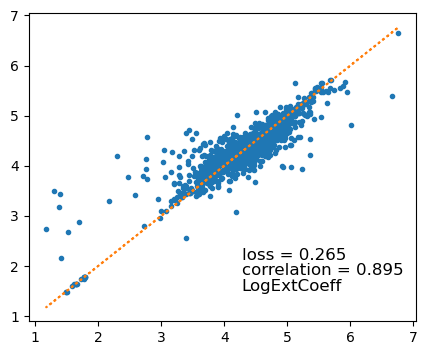

In [13]:
plot_rf_results(lec_y_test, lec_predicted, "LogExtCoeff")

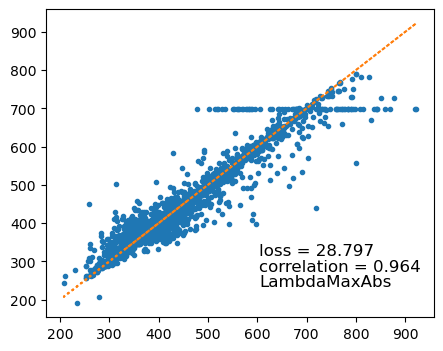

In [14]:
plot_rf_results(lma_y_test, lma_predicted, "LambdaMaxAbs")

## Add list of base molecules to explore and smarts of interest

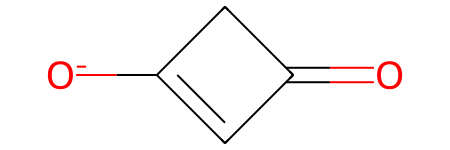

In [15]:
fluorene_smarts = "[#6]1-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2-1"
squaraine_smarts = "[#6]1=[#6](-[#8-])-[#6]-[#6]-1=[#8]"
fluorene = rdkit.Chem.MolFromSmarts(fluorene_smarts)
squaraine = rdkit.Chem.MolFromSmarts(squaraine_smarts)
squaraine


## Here we are going to reference the loc (index) number on the scrambled dataframe optdata. Use "base_mol_chooser.ipynb" to select your index numbers.

In [16]:
def mol_from_index(index, df):
    """
    Return mol from index number
    """
    # find Tag value for user entered index number and draw the molecule
    tag_value = df.Tag[index]
    print(f"Index number {index} has Tag value: {tag_value}")
    mol_from_index = rdkit.Chem.MolFromSmiles(df.Chromophore[index])
    smi = df.Chromophore[index]
    return mol_from_index, tag_value, smi




In [17]:
molecule_ids = [23, 6652, 180, 10906, 39, 7004, 11234, 84]

In [18]:
# Create an empty DataFrame
bases_df = pd.DataFrame(columns=['Name','og_index', 'Tag', 'smiles', 'MolObject'])

# List to store the new rows
rows = []

# Loop through the molecule_ids and store the Mol objects in the list
for mol_id in molecule_ids:
    object_name = f"LogExtCoeff_{mol_id}"
    mol_object, tag_value, smi = mol_from_index(mol_id, optdata_LogExtCoeff)
    rows.append({'Name': object_name, 'og_index': mol_id, 'Tag': tag_value, 'smiles':smi, 'MolObject': mol_object})

# Concatenate all the rows at once to create the DataFrame
bases_df = pd.DataFrame(rows)
bases_df



Index number 23 has Tag value: 3619
Index number 6652 has Tag value: 12208
Index number 180 has Tag value: 12177
Index number 10906 has Tag value: 12185
Index number 39 has Tag value: 15641
Index number 7004 has Tag value: 15359
Index number 11234 has Tag value: 4086
Index number 84 has Tag value: 12729


,Name,og_index,Tag,smiles,MolObject
0,LogExtCoeff_23,23,3619,CCCC1(CCC)c2cc(-c3ccco3)ccc2-c2ccc(-c3ccco3)cc21,<rdkit.Chem.rdchem.Mol object at 0x2ed348900>
1,LogExtCoeff_6652,6652,12208,CN(C)c1cccc2c1-c1ccccc1C2=O,<rdkit.Chem.rdchem.Mol object at 0x2ed348970>
2,LogExtCoeff_180,180,12177,Nc1cccc2c1-c1ccccc1C2=O,<rdkit.Chem.rdchem.Mol object at 0x2ed3489e0>
3,LogExtCoeff_10906,10906,12185,CNc1ccc2c(c1)C(=O)c1ccccc1-2,<rdkit.Chem.rdchem.Mol object at 0x2ed348a50>
4,LogExtCoeff_39,39,15641,CCCCC1(CCCC)c2cc(C#Cc3ccc4ccc5cccc6ccc3c4c56)c...,<rdkit.Chem.rdchem.Mol object at 0x2ed348ac0>
5,LogExtCoeff_7004,7004,15359,CN1C(=CC2=C([O-])C(=Cc3oc4ccccc4[n+]3C)C2=O)C(...,<rdkit.Chem.rdchem.Mol object at 0x2ed348b30>
6,LogExtCoeff_11234,11234,4086,Cc1ccccc1CN(Cc1ccccc1C)c1nc(C#N)c(N(Cc2ccccc2C...,<rdkit.Chem.rdchem.Mol object at 0x2ed348ba0>
7,LogExtCoeff_84,84,12729,C(=C/c1ccnc2ccccc12)\c1ccc(/C=C/c2ccnc3ccccc23...,<rdkit.Chem.rdchem.Mol object at 0x2ed348c10>


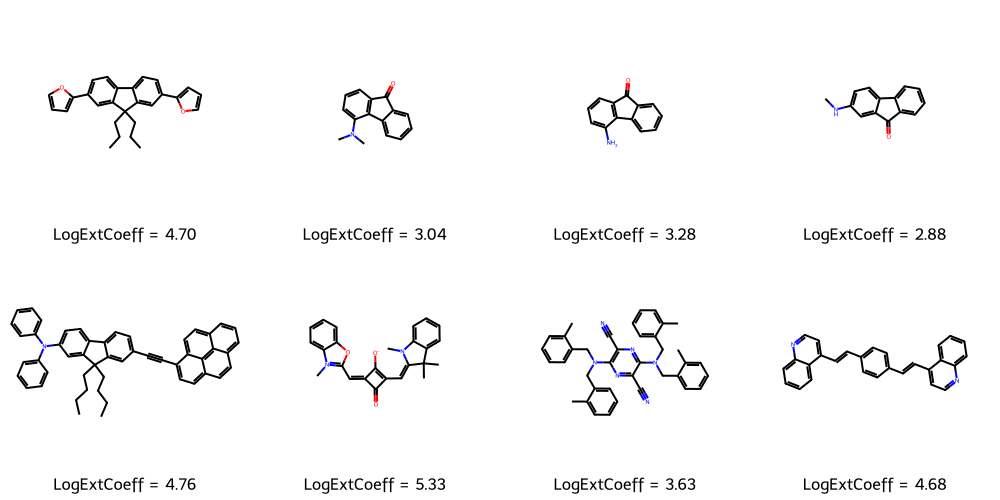

In [19]:
molstoplot = bases_df['MolObject'].tolist()
# Create legends for each molecule
legends = [f"LogExtCoeff = {optdata_LogExtCoeff.LogExtCoeff[id]:.2f}" for id in molecule_ids]
image = rdkit.Chem.Draw.MolsToGridImage(molstoplot, molsPerRow=4, subImgSize=(250, 250), legends=legends, useSVG=False)
# Save the image to a file
# image.save("molecules.png")
# Display the image inline in the Jupyter notebook
image

## Use exmol to generate the "space", and features for both models, or load from file

In [20]:
# Note that we are currently using a substructure preserver, as a default setting in exmol?

stoned_kwargs_5_5000 = {
    "num_samples": 5000,
    "alphabet": exmol.get_basic_alphabet(),
    "max_mutations": 5,
    # "preset": "synspace",
}

In [21]:
# Note that we are currently using a substructure preserver, as a default setting in exmol?

stoned_kwargs_2_2000 = {
    "num_samples": 2000,
    "alphabet": exmol.get_basic_alphabet(),
    "max_mutations": 2,
    # "preset": "synspace",
}

In [22]:
def space_pickle_load(filename: str):
    with open(filename, "rb") as fp:   # Unpickling
            loaded_space = pickle.load(fp)
    return loaded_space

## Run stoned

In [25]:
smiles_23 = optdata_LambdaMaxAbs.Chromophore[23]
smiles_23

'CCCC1(CCC)c2cc(-c3ccco3)ccc2-c2ccc(-c3ccco3)cc21'

In [26]:
num_samples = 5000
quiet = False
pbar = tqdm.tqdm(total=num_samples, disable=quiet)
result = run_stoned(
            smiles_23, _pbar=pbar, return_selfies=True, num_samples=5000, max_mutations=2, min_mutations=1)
selfies, smiles, scores = cast(Tuple[List[str], List[str], List[float]], result)

  0%|          | 0/5000 [00:00<?, ?it/s]

🥌STONED🥌 Filtering: 100%|██████████| 5000/5000 [00:04<00:00, 1072.91it/s]   

In [27]:
print(f"Number of unique molecules: {len(set(smiles))}")
print(f"Number of unique SELFIES: {len(set(selfies))}")
print (scores)

Number of unique molecules: 4206
Number of unique SELFIES: 4206
[0.371900826446281, 0.4098360655737705, 0.4396551724137931, 0.48484848484848486, 0.44642857142857145, 0.46153846153846156, 0.0970873786407767, 0.6435643564356436, 0.8555555555555555, 1.0, 0.3515625, 0.7894736842105263, 0.12087912087912088, 0.0, 0.5277777777777778, 0.28, 0.19424460431654678, 0.09345794392523364, 0.4180327868852459, 0.3230769230769231, 0.6372549019607843, 0.41228070175438597, 0.782608695652174, 0.4396551724137931, 0.38524590163934425, 0.3884297520661157, 0.3697478991596639, 0.7578947368421053, 0.4661016949152542, 0.5825242718446602, 0.4260869565217391, 0.5648148148148148, 0.8555555555555555, 0.5315315315315315, 0.6407766990291263, 0.7346938775510204, 0.5181818181818182, 0.6407766990291263, 0.23484848484848486, 0.5178571428571429, 0.29473684210526313, 0.375, 0.30158730158730157, 0.18333333333333332, 0.49122807017543857, 0.1826086956521739, 0.5794392523364486, 0.8977272727272727, 0.5596330275229358, 0.57692307

## Calculate features from smiles

In [36]:
# place smiles and scores into a dataframe
space_23_df = pd.DataFrame({'SMILES': smiles, 'scores': scores})
space_23_df.head()

,SMILES,scores
0,C=1(C2=CC=1CC=C(C=CC2(CCC)CCC)C=3OC=CC=3CC)C4=...,0.371901
1,C1(CCC)(CC(C=2C1=CC(C3=CC=CO3)=CC=2)=CC=C(C=C4...,0.409836
2,C1=C2C=3C(=CC(=CC=3)C4=CC=CO4)C(C=5CC)(CCC)C2=...,0.439655
3,C=C1C(C2=CC=C(C=C2C1(CCC)CCC)C3=CC=CO3)F,0.484848
4,C12=C3C(CC(C3=CC=C1C4=CC=CO4)=CC=C2C=5OC=CC=5)...,0.446429


In [39]:
molecules_space_23, raw_features_space_23 = get_mol_and_labels(calc, space_23_df, property = None, filepath = "data/space23_raw_features.pb")

100%|██████████| 4206/4206 [03:08<00:00, 22.37it/s]


In [41]:
print (type(raw_features_space_23))
raw_features_space_23.head()

<class 'mordred._base.pandas_module.MordredDataFrame'>


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,36.188648,2.567313,5.104187,36.188648,1.292452,4.280521,...,10.500757,79.419040,374.224580,6.452148,1845,47,150.0,183.0,8.090278,6.430556
1,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,39.165079,2.560327,4.963901,39.165079,1.305503,4.336892,...,10.332897,82.728507,401.235479,6.577631,2527,45,158.0,188.0,8.590278,6.791667
2,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,37.615861,2.661900,5.135954,37.615861,1.343424,4.299887,...,10.547576,81.499253,370.193280,6.855431,1725,54,158.0,198.0,7.201389,6.236111
3,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,28.567522,2.589993,5.006960,28.567522,1.298524,4.033360,...,10.243845,72.885550,298.173294,6.626073,954,39,118.0,146.0,7.479167,5.027778
4,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,35.150845,2.585297,5.041198,35.150845,1.351956,4.228765,...,10.338867,78.492348,342.161980,7.128375,1450,46,146.0,180.0,6.0,5.722222


In [54]:
feature_values_space_23, mordred_names_space_23 = clean_up_mordred_features(raw_features_space_23, calc, lec_selected_features)

In [55]:
print (type(mordred_names_space_23))
print (mordred_names_space_23[0:5])
print (len(mordred_names_space_23))
print (len(feature_values_space_23))

<class 'numpy.ndarray'>
['nAcid' 'nBase' 'nAromAtom' 'nAromBond' 'nAtom']
789
4206


In [61]:
print (type(feature_values_space_23))
lec_space_23 = lec_rf.predict(feature_values_space_23)
lma_space_23 = lma_rf.predict(feature_values_space_23)
print (type(lec_space_23))
print (len(lec_space_23))
space_23_df['LogExtCoeff'] = lec_space_23
space_23_df['LambdaMaxAbs'] = lma_space_23
space_23_df.head() 

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
4206


,SMILES,scores,LogExtCoeff,LambdaMaxAbs
0,C=1(C2=CC=1CC=C(C=CC2(CCC)CCC)C=3OC=CC=3CC)C4=...,0.371901,4.600125,394.467988
1,C1(CCC)(CC(C=2C1=CC(C3=CC=CO3)=CC=2)=CC=C(C=C4...,0.409836,4.508205,397.634786
2,C1=C2C=3C(=CC(=CC=3)C4=CC=CO4)C(C=5CC)(CCC)C2=...,0.439655,4.055033,393.284368
3,C=C1C(C2=CC=C(C=C2C1(CCC)CCC)C3=CC=CO3)F,0.484848,4.618344,341.600463
4,C12=C3C(CC(C3=CC=C1C4=CC=CO4)=CC=C2C=5OC=CC=5)...,0.446429,4.057778,390.120257


In [62]:
# Create a new DataFrame from the numpy array with the column names
new_dataframe = pd.DataFrame(feature_values_space_23, columns=mordred_names_space_23)
# Concatenate the new DataFrame with the existing DataFrame horizontally
result_dataframe = pd.concat([space_23_df, new_dataframe], axis=1)

result_dataframe.head()


,SMILES,scores,LogExtCoeff,LambdaMaxAbs,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
0,C=1(C2=CC=1CC=C(C=CC2(CCC)CCC)C=3OC=CC=3CC)C4=...,0.371901,4.600125,394.467988,0.0,0.0,10.0,10.0,58.0,28.0,...,7.167809,10.500757,79.419040,374.224580,6.452148,1845.0,47.0,150.0,183.0,6.430556
1,C1(CCC)(CC(C=2C1=CC(C3=CC=CO3)=CC=2)=CC=C(C=C4...,0.409836,4.508205,397.634786,0.0,0.0,11.0,11.0,61.0,30.0,...,7.803435,10.332897,82.728507,401.235479,6.577631,2527.0,45.0,158.0,188.0,6.791667
2,C1=C2C=3C(=CC(=CC=3)C4=CC=CO4)C(C=5CC)(CCC)C2=...,0.439655,4.055033,393.284368,0.0,0.0,11.0,11.0,54.0,28.0,...,8.055475,10.547576,81.499253,370.193280,6.855431,1725.0,54.0,158.0,198.0,6.236111
3,C=C1C(C2=CC=C(C=C2C1(CCC)CCC)C3=CC=CO3)F,0.484848,4.618344,341.600463,0.0,0.0,11.0,11.0,45.0,22.0,...,7.669962,10.243845,72.885550,298.173294,6.626073,954.0,39.0,118.0,146.0,5.027778
4,C12=C3C(CC(C3=CC=C1C4=CC=CO4)=CC=C2C=5OC=CC=5)...,0.446429,4.057778,390.120257,0.0,0.0,16.0,16.0,48.0,26.0,...,7.810758,10.338867,78.492348,342.161980,7.128375,1450.0,46.0,146.0,180.0,5.722222


### Question: How do we know logically that selected_features will be the same for all properties? We need to make sure it <i>is</i> the same!

In [28]:
def model_eval_lec(smiles):
    mols = [rdkit.Chem.MolFromSmiles(smi) for smi in smiles]
    raw_space_features = calc.pandas(mols, nproc=8, quiet=True)
    space_features = raw_space_features.values.astype(float)
    space_features = space_features[:, lec_selected_features]
    labels = lec_rf.predict(np.nan_to_num(space_features))
   
    return labels

In [29]:
def model_eval_lma(smiles):
    mols = [rdkit.Chem.MolFromSmiles(smi) for smi in smiles]
    raw_space_features = calc.pandas(mols, nproc=8, quiet=True)
    space_features = raw_space_features.values.astype(float)
    # space_features_lma = space_features_lma.values.astype(float)
    space_features = space_features[:, lma_selected_features]
    # space_features_lma = space_features_lma[:, features_select_lma]
    
    labels = lma_rf.predict(np.nan_to_num(space_features))
    # labels = clf.predict(np.nan_to_num(space_features))
    return labels

In [30]:
def load_existing_space_lma(space_filename: str, base_number: int, substructure_smarts: str = None, stoned_kwargs: dict = stoned_kwargs_2_2000):
    space_features_filename = space_filename + "_features"
    """Load an existing space from a pickle file, or create a new one if the file does not exist."""
    try:
        loaded_space = space_pickle_load(space_filename)
    except FileNotFoundError as e:
        smi = optdata_LogExtCoeff.Chromophore[base_number] # do we generalize here for other dfs?
        loaded_space = exmol.sample_space(smi, model_eval_lma, stoned_kwargs=stoned_kwargs,quiet=False, substructure_smarts = substructure_smarts)
        # loaded_space = exmol.sample_space(smi, model_eval, stoned_kwargs=stoned_kwargs,quiet=False, substructure_smarts = substructure_smarts)
        with open(space_filename, "wb") as fp:   #Pickling
            pickle.dump(loaded_space, fp)
        # loaded_space_features = space_features_global
        # with open(space_features_filename, "wb") as fp:   #Pickling
            # pickle.dump(loaded_space_features, fp)

    # return loaded_space

    # # Extract the features from the global dictionary and build a dataframe
    # smiles_list = [example.smiles for example in loaded_space]
    # features_data = [features_dict[smi] for smi in smiles_list]
    # features_df = pd.DataFrame(features_data)

    return loaded_space  #, features_df

In [31]:
def load_existing_space(space_filename: str, base_number: int, substructure_smarts: str = None, stoned_kwargs: dict = stoned_kwargs_2_2000):
    space_features_filename = space_filename + "_features"
    """Load an existing space from a pickle file, or create a new one if the file does not exist."""
    try:
        loaded_space = space_pickle_load(space_filename)
    except FileNotFoundError as e:
        smi = optdata_LogExtCoeff.Chromophore[base_number] # do we generalize here for other dfs?
        loaded_space = exmol.sample_space(smi, model_eval, stoned_kwargs=stoned_kwargs,quiet=False, substructure_smarts = substructure_smarts)
        # loaded_space = exmol.sample_space(smi, model_eval, stoned_kwargs=stoned_kwargs,quiet=False, substructure_smarts = substructure_smarts)
        with open(space_filename, "wb") as fp:   #Pickling
            pickle.dump(loaded_space, fp)
        # loaded_space_features = space_features_global
        # with open(space_features_filename, "wb") as fp:   #Pickling
            # pickle.dump(loaded_space_features, fp)

    # return loaded_space

    # # Extract the features from the global dictionary and build a dataframe
    # smiles_list = [example.smiles for example in loaded_space]
    # features_data = [features_dict[smi] for smi in smiles_list]
    # features_df = pd.DataFrame(features_data)

    return loaded_space  #, features_df

In [32]:
# convert the space dictionary to a dataframe
def space_features_for_mordred_calc(space_features):
    df = pd.DataFrame(space_features)
    return df

def space_features_to_df_full_conversion_with_mols(space_features):
    space_features_df = pd.DataFrame(columns = ['smiles', 'selfies', 'similarity', 'yhat', 'index', 'position', 'is_origin', 'cluster', 'label', 'descriptors'])
    for i in range(len(space_features)):
        space_features_df.loc[i] = [space_features[i].smiles, space_features[i].selfies, space_features[i].similarity,
                                space_features[i].yhat, space_features[i].index, space_features[i].position,
                                space_features[i].is_origin, space_features[i].cluster, space_features[i].label,
                                space_features[i].descriptors]
     
    # append a column with rdKit mol objects
    space_features_df['mol'] = space_features_df.smiles.apply(rdkit.Chem.MolFromSmiles)
    return space_features_df


def get_space_features(space_filename, space_filename_str: str, mordred_calc, features_select_first, features_select_second, clf_first, clf_second):
    # # convert the space dictionary to a dataframe
    # I don't think this is actually necessary
    # def space_features_to_df(space_features):
    #     df = pd.DataFrame(space_features)
    #     return df

    space_features_filename_pb = space_filename_str + "_features.pb"
    # Note that we don't need to do more than unpack the list to get one item of "smiles" in order to run the mordred calculator
    space_filename_df = space_features_for_mordred_calc(space_filename)
    print (f"the type of the space_filename_df is: {type(space_filename_df)}")
    print (f"the shape of space_filename_df is: {space_filename_df.shape}")

    molecules = []
    for smi in space_filename_df.smiles:
        mol = rdkit.Chem.MolFromSmiles(smi)
        molecules.append(mol)

    # This weeds out molecules that can't be parsed by RDKit. There are none in opvdata
    valid_mol_idx = [bool(m) for m in molecules]
    valid_mols = [m for m in molecules if m]

    # calculating mordred features is time consuming so we work with precalculated features
    try:
        raw_space_features = pd.read_pickle(space_features_filename_pb)
    except FileNotFoundError as e:
        raw_space_features = mordred_calc.pandas(valid_mols, nproc=8, quiet=False)
        raw_space_features.to_pickle(space_features_filename_pb)

    print (type(raw_space_features))
    
    raw_space_features = raw_space_features.values.astype(float)

    space_features = raw_space_features[:, features_select_first]
    space_features_lma = raw_space_features[:, features_select_second]

    
    # Don't need this any more
    # space_features = feature_convert_local(raw_space_features, fm_first, fs_first)
    # space_features_lma = feature_convert_local(raw_space_features, fm_second, fs_second)

    # One concern here is that we must use the same global list of features_select for each model 
    # The following code is commented out, because I think we just have to make sure that features_select and features_select_lma
    # are made available globally  
    # space_features_select_LogExtCoeff = np.all(np.isfinite(space_features), axis=0)
    # space_features_select_lma = np.all(np.isfinite(space_features_lma), axis=0)

    
    
    space_labels_LogExtCoeff = clf_first.predict(np.nan_to_num(space_features))
    space_labels_lma = clf_second.predict(np.nan_to_num(space_features_lma))
    print (f"the type of the space_features is: {type(space_features)}")
    print (f"the shape of space_features is: {space_features.shape}")
  
    return space_features, space_features_lma, space_labels_LogExtCoeff, space_labels_lma, raw_space_features
    
   

In [33]:
def set_and_forget_space_features_generator(space_filename_str: str, base_number: int, substructure_smarts: str = None, stoned_kwargs: dict = stoned_kwargs_2_2000, mordred_calc = calc, features_select_first = lec_selected_features, features_select_second = lma_selected_features, clf_first = lec_rf, clf_second = lma_rf):
    loaded_space = load_existing_space(space_filename_str, base_number, substructure_smarts, stoned_kwargs)
    space_features, space_features_lma, space_labels_LogExtCoeff, space_labels_lma, raw_space_features = get_space_features(loaded_space, space_filename_str, mordred_calc, features_select_first, features_select_second, clf_first, clf_second)
    loaded_space_df = space_features_to_df_full_conversion_with_mols(loaded_space)
    return loaded_space, space_features, space_features_lma, space_labels_LogExtCoeff, space_labels_lma, raw_space_features, loaded_space_df
    

In [34]:
# This won't work because the exmol.sample_space function is pulling from the installed version of exmol, not the local version
space_LogExtCoeff_6652_2_2000_5_04_2023, space_LogExtCoeff_6652_2_2000_5_04_2023_features, space_LogExtCoeff_6652_2_2000_5_04_2023_features_lma, space_LogExtCoeff_6652_2_2000_5_04_2023_labels_LogExtCoeff, space_LogExtCoeff_6652_2_2000_5_04_2023_labels_lma, raw_space_features_LogExtCoeff_6652_2_2000_5_04_2023, space_LogExtCoeff_6652_2_2000_5_04_2023_df = set_and_forget_space_features_generator("space_LogExtCoeff_6652_2_2000_5_04_2023", 6652, substructure_smarts = None, stoned_kwargs = stoned_kwargs_2_2000, mordred_calc = calc, features_select_first = lec_selected_features, features_select_second = lma_selected_features, clf_first = lec_rf, clf_second = lma_rf)


NameError: name 'model_eval' is not defined

🥌STONED🥌 Filtering: 100%|██████████| 5000/5000 [00:20<00:00, 1072.91it/s]